In [1]:
import polars as pl 
import re
import yaml 
from utils.process import get_specie


cov = 0.5

# Load yaml file
with open('/home/simon.herman/Bureau/Gits/Elongates/env.yaml', 'r') as f:
    yaml_data = yaml.safe_load(f)
    species_dict = {k: v for d in yaml_data['Regex'].values() for k, v in d.items()}
    species_order = yaml_data['Species_order']['Scer']
    re_dict = yaml_data['Regex']['Scer']


def is_monophyletic(binary_vector):
    
    two_index = binary_vector.index(2)

    ones_after_two = binary_vector[two_index:]
    start_index = ones_after_two.index(1) + two_index
    end_index = len(ones_after_two) - 1 - ones_after_two[::-1].index(1) + two_index

    if 1 in binary_vector[:two_index] or 0 in binary_vector[start_index:end_index+1]:
        return False
    else:
        return True

    
def parse_blast_dataframe(row : tuple) -> tuple:

    query_pattern = r'(.*?)-(cluster_n\d+)'
    subject_pattern = r'(.*?)-(cluster_n\d+)-.*-(f\d+)-.*'

    query_id = row[0]
    subject_id = row[1]
    evalue = row[2]
    qstart = row[3]
    qend = row[4]
    sstart = row[5]
    send = row[6]
    qseq = row[7]
    sseq = row[8]
    length = row[9]
    blast_gapopen = row[10]
    blast_gaps = row[11]



    query_matches = re.match(query_pattern, query_id)
    query_seq_id = query_matches.group(1) if query_matches else None
    query_cluster = query_matches.group(2) if query_matches else None

    subject_matches = re.match(subject_pattern, subject_id)
    subject_seq_id = subject_matches.group(1) if subject_matches else None
    subject_cluster = subject_matches.group(2) if subject_matches else None
    subject_relative_frame = subject_matches.group(3) if subject_matches else None

    is_same_cluster = int(query_cluster == subject_cluster)
    q_specie = get_specie(re_dict, query_seq_id)
    s_specie = get_specie(re_dict, subject_seq_id)

    tuple_ = tuple([query_seq_id, subject_seq_id, evalue, qstart, qend, sstart, send, 
                    qseq, sseq, length, blast_gapopen, blast_gaps, query_cluster, subject_cluster, subject_relative_frame, 
                    is_same_cluster, q_specie, s_specie])
    return tuple_


def analyze_monophyly(dataframe, species_order):

    tmp_id = list()
    tmp_vector = list()
    tmp_bool = list()

    for query, matches in dataframe.groupby("qseqid"):
        if len(matches["q_specie"].unique().to_list()) > 1:
            raise KeyError("Multiple query species found")
        else:
            q_specie = matches["q_specie"].unique().to_list()[0]  # Supposedly only one query specie

        species = matches["s_specie"].unique().to_list()
        species = [1 if item in species else 0 for item in species_order]
        try:
            index = species_order.index(q_specie)
            species[index] = 2
        except ValueError:
            pass

        tmp_id.append(query)
        tmp_vector.append(str(species))
        try:
            tmp_bool.append(False if 0 in species[2 : len(species) - species[::-1].index(1)] else True)
        except ValueError:
            tmp_bool.append(True) # If only 2 in the vector, q_specie == s_specie 


    result_df = pl.DataFrame({
        'query': tmp_id,
        'vector': tmp_vector,
        'is_monophyletic': tmp_bool
    })

    dataframe = dataframe.join(result_df, left_on="qseqid", right_on="query")

    return dataframe

####################

# NTER

####################

columns =  ["qseqid", "sseqid", "evalue", "qstart", "qend", "sstart", "send", "qseq", "sseq", "length", "blast_gapopen", "blast_gaps"]
df_blast_nter  = pl.read_csv(f"output/{cov}/nter_five_{cov}.tsv", separator="\t", has_header = False)
df_blast_nter.columns = columns

df_blast_nter = df_blast_nter.with_columns(
    pl.lit("NA").alias('query_cluster'),
    pl.lit("NA").alias('subject_cluster'),
    pl.lit("NA").alias('relative_frame'),
    pl.lit("NA").alias('same_cluster'),
    pl.lit("NA").alias('q_specie'),
    pl.lit("NA").alias('s_specie')
)


columns = df_blast_nter.columns
df_blast_nter = df_blast_nter.apply(parse_blast_dataframe)
df_blast_nter.columns = columns


nter_elongates_data = pl.read_csv(f"output/{cov}/{cov}_elongates.csv").select("cluster_size","seq_id",
                                                           "Nter_gaps","Nter_gap_openings","Nter_nb_aa",
                                                           "Nter_elongate_length","Nter_ratio",
                                                           "is_max_Nter","is_min_Nter",
                                                           "Nter_event_ID","Nter_events",
                                                           "Meth_after_Nter")



df_nter = df_blast_nter.join(nter_elongates_data, left_on="qseqid", right_on="seq_id", how = "inner")
df_nter = df_nter.filter((pl.col("same_cluster") == 1))
df_nter = analyze_monophyly(df_nter, species_order)


####################

# CTER

####################

columns =  ["qseqid", "sseqid", "evalue", "qstart", "qend", "sstart", "send", "qseq", "sseq", "length", "blast_gapopen", "blast_gaps"]
df_blast_cter  = pl.read_csv(f"output/{cov}/cter_three_{cov}.tsv", separator="\t", has_header = False)
df_blast_cter.columns = columns



df_blast_cter = df_blast_cter.with_columns(
    pl.lit("NA").alias('query_cluster'),
    pl.lit("NA").alias('subject_cluster'),
    pl.lit("NA").alias('relative_frame'),
    pl.lit("NA").alias('same_cluster'),
    pl.lit("NA").alias('q_specie'),
    pl.lit("NA").alias('s_specie')
)


columns = df_blast_cter.columns
df_blast_cter = df_blast_cter.apply(parse_blast_dataframe)
df_blast_cter.columns = columns


cter_elongates_data = pl.read_csv(f"output/{cov}/{cov}_elongates.csv").select("cluster_size","seq_id",
                                                           "Cter_gaps","Cter_gap_openings","Cter_nb_aa",
                                                           "Cter_elongate_length","Cter_ratio",
                                                           "is_max_Cter","is_min_Cter",
                                                           "Cter_event_ID","Cter_events")



df_cter = df_blast_cter.join(cter_elongates_data, left_on="qseqid", right_on="seq_id", how = "inner")
df_cter = df_cter.filter((pl.col("same_cluster") == 1))
df_cter = analyze_monophyly(df_cter, species_order)





In [2]:

common_sorting = (
                ((pl.col("q_specie") == "Scer_NCBI") | (pl.col("q_specie") == "Spar_NCBI")) &
                (pl.col("evalue") < 0.5)  
                 
                     
                )

nter_filtered = df_nter.filter(common_sorting & (pl.col("Nter_elongate_length") < 60))
cter_filtered = df_cter.filter(common_sorting & (pl.col("Cter_elongate_length") < 60))



print(f"Nter : {nter_filtered.shape}")
print(f"Cter : {cter_filtered.shape}")

spe_nter = (pl.col("qstart") < 5) & (pl.col("sstart") < pl.col("length") + 5) & (pl.col("sstart") > pl.col("length") - 5)


Nter : (352, 31)
Cter : (150, 30)


In [32]:
nter_filtered.sort("evalue","query_cluster").write_csv(f"output/{cov}/nter_filtered.csv")
cter_filtered.sort("evalue","query_cluster").write_csv(f"output/{cov}/cter_filtered.csv")



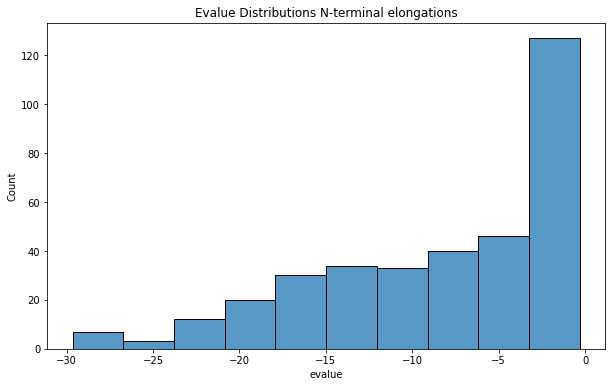

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


plt.figure(figsize=(10, 6))
sns.histplot( x = np.log10(nter_filtered['evalue']), data=nter_filtered.select("evalue").to_pandas())
plt.title('Evalue Distributions N-terminal elongations')
plt.show()

In [ ]:


nter_multiple_frames_queries = pl.DataFrame()
cter_multiple_frames_queries = pl.DataFrame()

for i,j in nter_filtered.groupby("qseqid","sseqid"):

    if j.shape[0] > 1:
        
        nter_multiple_frames_queries = pl.concat([nter_multiple_frames_queries, j])

for i,j in cter_filtered.groupby("qseqid","sseqid"):

    if j.shape[0] > 1:
        
        cter_multiple_frames_queries = pl.concat([cter_multiple_frames_queries, j])

nter_multiple_frames_queries.sort(by = "s_specie").write_csv(f"output/{cov}/nter_multiple_frames_queries.csv")
cter_multiple_frames_queries.sort(by = "s_specie").write_csv(f"output/{cov}/cter_multiple_frames_queries.csv")